# Tutorial: Programming with Pulser

This tutorial demonstrates how to use Pulser to program the evolution of a quantum system. In a first part, we excite one atom from its ground state to its excited state using a constant pulse. In a second part, we show how to prepare a quantum system of 9 atoms in an anti-ferromagnetic state using time-dependent pulses.

This tutorial follows the step-py-step guide on how to create a quantum program using Pulser that is provided in the [programming page](docs/programming.md). For more information regarding the steps followed and the mathematical objects at stake, please refer to this page.

In [1]:
import numpy as np
import pulser

## Programming a constant Hamiltonian without interaction: Exciting one atom in the Rydberg state

As presented in ["Programming a neutral-atom QPU"](../docs/source/programming.md), Pulser enables you to program [an Hamiltonian $H$](../docs/source/programming.md#2-hamiltonian-evolves-the-state) composed of an [interaction Hamiltonian](../docs/source/programming.md#22-interaction-hamiltonian) and a [drive Hamiltonian](../docs/source/programming.md#21-driving-hamiltonian).

Let's program this Hamiltonian such that an atom initially in the ground state $\left|g\right>$ is measured in the rydberg state $\left|r\right>$ after a time $\Delta t$.

Since we are working with a single atom, there is no [interaction Hamiltonian](../docs/source/programming.md#22-interaction-hamiltonian). In this specific example, $H=H^D$. For a simple pulse having a duration $\Delta t$, an amplitude constant along time $\Omega$, detuning $\delta=0$ and phase $\phi=0$ [the Hamiltonian between $0$ and $\Delta t$ is](../docs/source/programming.md#21-driving-hamiltonian):

$$ H(t) = \frac{\Omega}{2} (|g\rangle\langle r| + |r\rangle\langle g|)$$

<details>
<summary>To find the atom in the Rydberg state at the end of the program, we choose Δt=1000ns and Ω=π rad/μs</summary>

The initial state being the ground state and the Hamiltonian $H$ being constant along time, [the final state is](../docs/source/programming.md#2-hamiltonian-evolves-the-state):

$$
\begin{align}
\left|\Psi_f\right> &= e^{-i H \Delta t} \left|g\right> \\
&= \left(\cos\left(\frac{\Omega}{2} \Delta t\right)(|g\rangle\langle g| + |r\rangle\langle r|) - i \sin\left(\frac{\Omega}{2} \Delta t\right)(|g\rangle\langle r| + |r\rangle\langle g|)\right)\left|g\right>\\
&= \cos\left(\frac{\Omega}{2} \Delta t\right)\left|g\right> - i \sin\left(\frac{\Omega}{2} \Delta t\right)\left|r\right>
\end{align}
$$

The final state will be the Rydberg state $\left|r\right>$ if $\frac{\Omega}{2} \Delta t = \frac{\pi}{2}$. From this condition, we choose $\Delta t = 1000\ ns$ and $\Omega=\pi\ rad/\mu s$.
</details>

### 1. Picking a `Device`

We need a `Device` that will enable us to target the transition between the ground and the rydberg state. The `Device` `pulser.AnalogDevice` contains the `Rydberg.Global` channel, that targets the transition between these two states. Let's select this `Device` !

We can check in the device specifications (accessed via `Device.specs`) that the `AnalogDevice` supports the ground-rydberg transition.

In [2]:
device = pulser.AnalogDevice
print(device.specs)


Register parameters:
 - Dimensions: 2D
 - Rydberg level: 60
 - Maximum number of atoms: 25
 - Maximum distance from origin: 35 µm
 - Minimum distance between neighbouring atoms: 5 μm
 - SLM Mask: No

Layout parameters:
 - Requires layout: Yes
 - Accepts new layout: No
 - Minimal number of traps: 1
 - Maximum layout filling fraction: 0.5

Device parameters:
 - Maximum number of runs: 2000
 - Maximum sequence duration: 4000 ns
 - Channels can be reused: No
 - Supported bases: ground-rydberg
 - Supported states: r, g
 - Ising interaction coefficient: 865723.02

Channels:
 - 'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=125.66370614359172, max_amp=12.566370614359172, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=100000000, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=RydbergEOM(limiting_beam=<RydbergBeam.RED: 2>, max_limiting_amp=188.49555921538757, intermediate_detuning=2827.

### 2. Creating the `Register`

We want to excite one atom. There will therefore be only one atom in the `Register`, whose position does not matter because it will not interact with another atom.

Let's then create a `Register` containing one atom at the coordinate (0, 0).

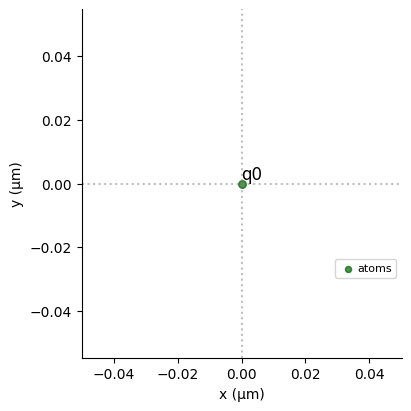

In [3]:
register = pulser.Register.from_coordinates([(0, 0)], prefix="q")
register.draw()

At this stage, we can initialize the `Sequence`, our quantum program. This will check that the created `Register` matches the parameters set by the `Device` we picked. 

In [4]:
sequence = pulser.Sequence(register, device)

### 3. Picking the Channels

The only channel we need to pick is a `Rydberg` channel to target the transition between $\left|g\right>$ and $\left|r\right>$. Since we only have one atom, the addressing does not matter, the `Rydberg.Global` channel will address the atom in the register. 

In [5]:
print("The available channels were", sequence.available_channels)
sequence.declare_channel("ch_0", "rydberg_global")
print(
    "The states used in the computation are", sequence.get_addressed_states()
)

The available channels were {'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=125.66370614359172, max_amp=12.566370614359172, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=4, min_duration=16, max_duration=100000000, min_avg_amp=0, mod_bandwidth=8, custom_phase_jump_time=None, eom_config=RydbergEOM(limiting_beam=<RydbergBeam.RED: 2>, max_limiting_amp=188.49555921538757, intermediate_detuning=2827.4333882308138, controlled_beams=(<RydbergBeam.BLUE: 1>,), mod_bandwidth=40, custom_buffer_time=240, multiple_beam_control=True, blue_shift_coeff=1.0, red_shift_coeff=1.0), propagation_dir=None)}
The states used in the computation are ['r', 'g']


At this stage, the atom is initialized in the ground state $\left|g\right>$ and only two energy levels are used in the computation: the state of the system is described by a qubit.

### 4. Adding the pulses

Let's now add the pulse of duration $\Delta t = 1000\ ns$, amplitude $\Omega=\pi\ rad/\mu s$, detuning $\delta=0$ and phase $\phi=0$ to the `Rydberg.Global` channel to modify the state of the atom and make it reach the state $\left|r\right>$.

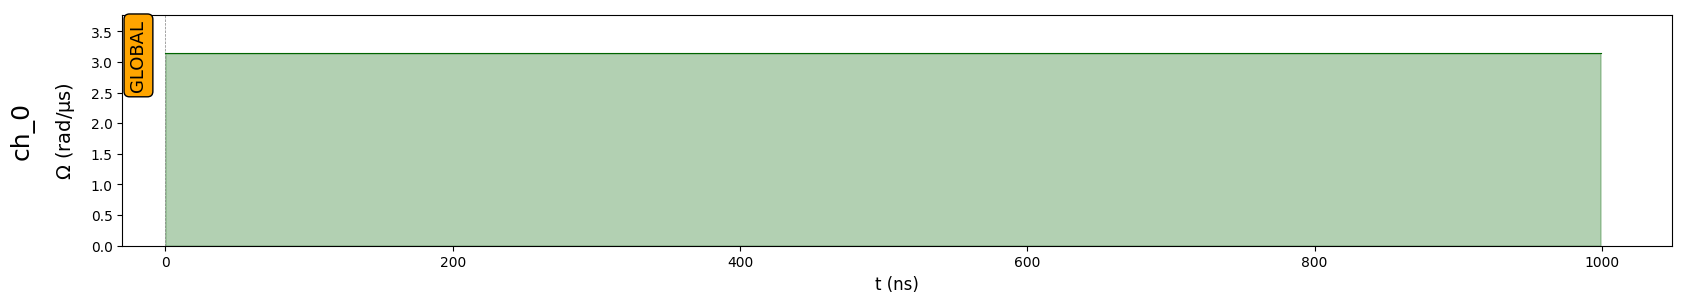

In [6]:
pi_pulse = pulser.Pulse.ConstantPulse(1000, np.pi, 0, 0)
sequence.add(pi_pulse, "ch_0")
sequence.draw(mode="input")

### Executing the Pulse Sequence

We are now done with our first Pulser program! We can now submit it to a backend for execution. Pulser provides multiple backends, notably the QPUs, but also a backend to simulate small quantum systems on your laptop based on **QuTip**. Let's use this `QutipBackend` to simulate the final state of the system: 

In [7]:
backend = pulser.backends.QutipBackend(sequence)
result = backend.run()

When running an experiment on a neutral-atom QPU, the output of the quantum program is the sampling of the final state. It is a dictionnary associating to each measured state the number of times it was measured.

In [8]:
result.sample_final_state(1000)

Counter({'1': 1000})

When measuring in the ground-rydberg basis, [the ground state is labelled "0" and the rydberg state "1"](../docs/source/conventions.md#state-preparation-and-measurement). For each of the 1000 measurements we did, the atom was measured in the Rydberg state, which means we designed our quantum program correctly !